In [7]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from Ctorch import *
from functions import *
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.signal import fftconvolve
from skimage import io
from scipy.fftpack import idct
from model import *
from tqdm import tnrange,tqdm_notebook
import PIL
from dataloaders import *
from visualise import *
from time import time
torch.cuda.set_device(0)
import shutil
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
%matplotlib inline

# Standard data type: batches of shape NxCxHxWx2

In [9]:
# compute loss
def compute_loss_cuda(model,x,y,k,lam):
    batch_net = model((y.cuda(),k.cuda(),lam.cuda()));
    loss = -10*torch.log10((1/nn.functional.mse_loss(batch_net[:,:,11:-11,11:-11],x.cuda())));
    #loss = nn.functional.mse_loss(batch_net[:,:,11:-11,11:-11],x.cuda());
    return loss;

def are_nans(net):
    """
        Function for checking network weight for NaNs
        
        Input:
        
            - net[torch.nn.Module]: network which weights to check
        
        Output:
            - [bool]: True - there are NaNs, False - there is no NaNs in weights
    """
    u = 0;
    for i in range(len(list(net.parameters()))):
        u = u + torch.sum(torch.isnan(list(net.parameters())[i]));
    return u!=0;

def save_checkpoint(state, is_best, filename='checkpoint.pt'):
    """
        Function for saving current training state checkpoint
        
        Input:
        
            - state[dict]: dict with network and optimizer weights
            
            - is_best[bool]: for saving checkpoint with best performance
        
        Output: None
    """
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pt')
    pass

def train(model,num_epochs,directory,b_size,dictname='FNet',pretrained=None,gpu=0):
    """
        Function for training.
        
        Input:
            - model[torch.nn.Module]: network for loss computation
            
            - num_epochs[int]: number of epochs to perform
            
            - directory[string]: directory to dataset
            
            - b_size[int]: minibatch size during training
            
            - dictname[string]: name of folders and tensorboard tags corresponding to this training routine
            
            - pretrained[string]: path to pretrained checkpoint to coninue training
            
            - gpu[int]: ID of GPU to use in training
            
        Output: None
    """
    is_best = False;
    
    # creating folders
    if not(os.path.isdir('tboard/' + dictname)):
        os.mkdir(('tboard/' + dictname));
    if not(os.path.isdir('trained/' + dictname)):
        os.mkdir(('trained/' + dictname));
    writer = SummaryWriter(log_dir=('tboard/' + dictname));
    
    # loading dataset for training
    trainset = TrainDataset_synth(directory);
    trainloader = DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=3);
    
    # optimizer
    opt = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=1e-6,amsgrad=True);
    
    model.cuda()
    
    # loading checkpoint
    start_epoch = 0;
    if pretrained:
        if os.path.isfile(pretrained):
            print("=> loading checkpoint '{}'".format(pretrained))
            checkpoint = torch.load(pretrained,map_location=lambda storage, loc: storage.cuda(gpu));
            start_epoch = checkpoint['epoch'] + 1;
            model.load_state_dict(checkpoint['state_dict']);
            opt.load_state_dict(checkpoint['optimizer']);
            print("=> loaded checkpoint '{}' (epoch {})".format(pretrained, checkpoint['epoch']));
            del checkpoint;
        else:
            print("=> no checkpoint found at '{}'".format(pretrained));
    torch.cuda.empty_cache();
    # Full pass over the training data
    for epoch in tnrange(start_epoch,num_epochs+start_epoch):
        
        torch.manual_seed(6838019176185359526 - epoch);
        np.random.seed(1431655765 - epoch);
        torch.cuda.manual_seed_all(6838019176185359526 - epoch);
        
        # number of passes in 1 epoch
        l = len(trainloader);
        
        # timings
        times = time();
        
        # Training network mode for dropouts and batchnorms
        model.train(True);
        # Train on batch
        for i_batch, (x,y,k,l) in enumerate((trainloader)):
            # obtaining loss
            loss = compute_loss_cuda(model,x,y,k,l);
            
            # writing to TensorBoard
            writer.add_scalar('Training loss', loss.data.cpu(), (epoch*len(trainloader) + i_batch)*trainloader.batch_size);
            opt.zero_grad()
            loss.backward()
            opt.step()

        # writing to TensorBoard
        writer.add_scalar('Training time', time() - times, epoch);
        writer.add_image('Learnable filters', visualise_weights(model.state_dict()['filters'].detach().cpu()), epoch);
        writer.add_image('Init convolution weights', visualise_weights(model.cnn.conv0.weight.detach().cpu()), epoch);
        
        if are_nans(model):
            print('NaNs:', 'NaNs detected in weights!', epoch)
            #writer.add_text('NaNs:', 'NaNs detected in weights!', epoch)
            break
    
        if (epoch)%30 == 0:
            save_checkpoint({
                    'epoch': epoch,
                    'arch': 'FDN',
                    'state_dict': model.state_dict(),
                    'optimizer' : opt.state_dict(),
                    }, is_best, filename=('trained/' + dictname + '/' + 'FDN' + '_epoch_' + str(epoch) + '.pt'));
            is_best = False;
    
    writer.close();
    pass
'''
        # is best in terms of validation loss?
        if valloss < minloss:
            minloss = valloss;
            is_best = True;

        
'''

'\n        # is best in terms of validation loss?\n        if valloss < minloss:\n            minloss = valloss;\n            is_best = True;\n\n        \n'

In [10]:
net = FourierDeconvolution(stage=1,grayscale=True);
net.cuda();
#net.load_state_dict(torch.load('trained/init_train.pt'));

/home/koshelev/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [11]:
train(net,1500,'dataset/Sun/',4,gpu=0,dictname='FNet_stage1',pretrained='trained/FNet_stage1/FDN_epoch_3270.pt');

=> loading checkpoint 'trained/FNet_stage1/FDN_epoch_3270.pt'
=> loaded checkpoint 'trained/FNet_stage1/FDN_epoch_3270.pt' (epoch 3270)


OSError: [Errno 12] Cannot allocate memory

In [5]:
torch.save(net.state_dict(),'trained/init_train.pt');

In [23]:
import torch
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchvision.transforms import ToTensor
from PIL.Image import open as imopen

def colorbar(mappable):
    ax = mappable.axes;
    fig = ax.figure;
    divider = make_axes_locatable(ax);
    cax = divider.append_axes("right", size="5%", pad=0.05);
    return fig.colorbar(mappable, cax=cax);

def plot2writer(fig):
    """Export pyplot figure to tensor image for writing in TensorBoardX."""
    buf = BytesIO();
    fig.savefig(buf, format='png');
    buf.seek(0);
    image = imopen(buf);
    image = ToTensor()(image);
    plt.close('all');
    return image;

def visualise_weights(layer_weights,nv=6,nh=4,w=6.75,h=10):
    fig, axes = plt.subplots(nv, nh, figsize=(w, h));
    for i in range(nv):
        for j in range(nh):
            im = axes[i][j].imshow(layer_weights[i*nh+j,0,:,:]);
            axes[i][j].axis('off');
            colorbar(im);
    return plot2writer(fig);

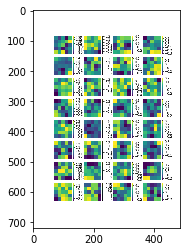

In [42]:
plt.imshow(visualise_weights(net.cnn.conv0.weight.detach().cpu(),nv=8,nh=4,w=6.75,h=10).permute(1,2,0))

In [39]:
net.cnn.conv0.weight.detach().cpu().shape

torch.Size([32, 1, 5, 5])

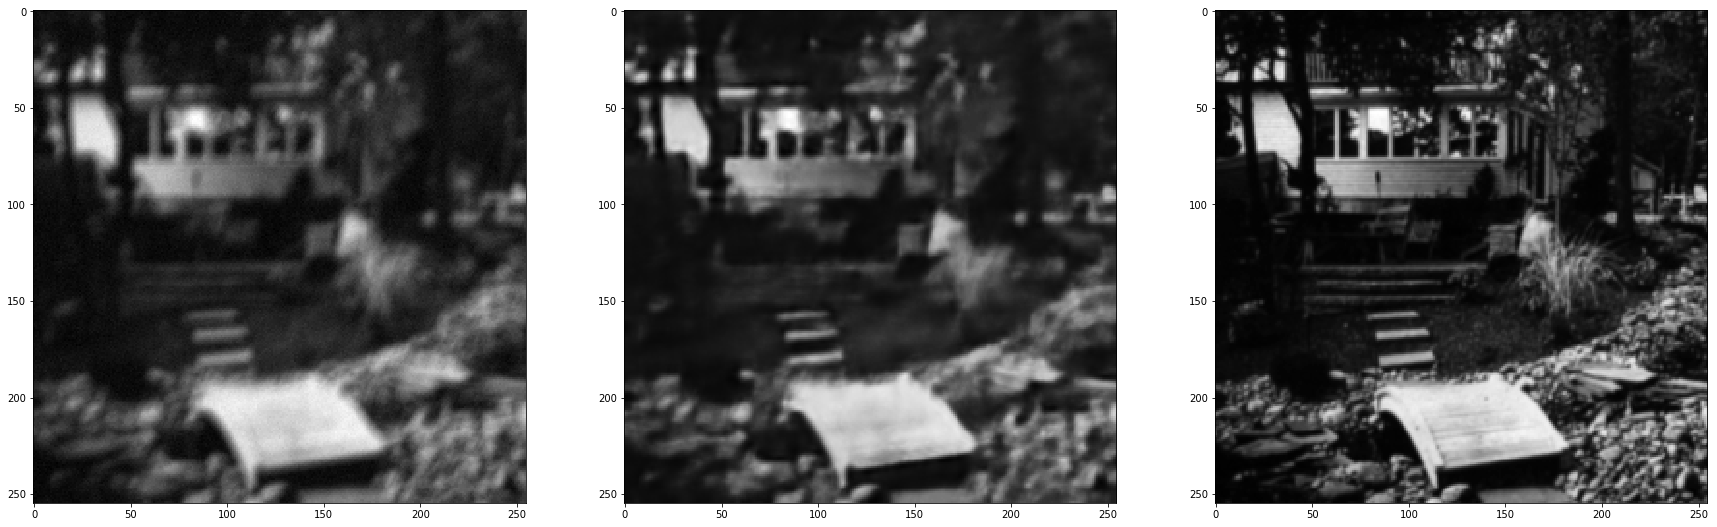

In [87]:
i = 0;
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(30,30));
ax[0].imshow(y[i,0,:,:],cmap='gray');
ax[1].imshow(inference[i,0,11:-11,11:-11],cmap='gray');
ax[2].imshow(x[i,0,:,:],cmap='gray');